In [22]:
import torch
import torch.nn as nn
import numpy as np
import einops
import os, sys, math, time
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from transformers import ResNetForImageClassification, AutoImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, CenterCrop

# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using PyTorch version {torch.__version__} with GPU...")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using PyTorch version 2.3.0 with GPU...


In [ ]:
# Data preparation
dataset = load_dataset("Hemg/Brain-Tumor-MRI-Dataset")
split = dataset["train"].train_test_split(test_size=0.1)
train_ds = split["train"]
val_ds = split["test"]
num_classes = len(train_ds.features["label"].names)

# Dataset Class
class ResNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return {
            "pixel_values": image,
            "labels": torch.tensor(label, dtype=torch.long)
        }

# resnet components
model_name = "microsoft/resnet-50"
image_processor = AutoImageProcessor.from_pretrained(model_name)

# create ResNet-specific transforms
resnet_transforms = Compose([
    Resize((image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])),
    ToTensor(),
    Normalize(
        mean=image_processor.image_mean,
        std=image_processor.image_std
    ),
])


In [11]:
# create datasets with proper transforms
train_dataset = ResNetDataset(train_ds, transform=resnet_transforms)
val_dataset = ResNetDataset(val_ds, transform=resnet_transforms)

# create model
model = ResNetForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]).to(device),
        "labels": torch.tensor([x["labels"] for x in batch]).to(device)
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./resnet-brain-tumor",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    use_mps_device=True,
    weight_decay=0.01,
    fp16=False,
    dataloader_pin_memory=False,
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=3e-4,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

start_time = time.time()

# Start training
trainer.train()

# Calculate total time
total_time = time.time() - start_time

# Convert to readable format
minutes, seconds = divmod(total_time, 60)
hours, minutes = divmod(minutes, 60)
print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Save model
trainer.save_model("./resnet-brain-tumor-final")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.385600,0.099105,0.974395
2,0.100900,0.061386,0.980085
3,0.048500,0.047241,0.990043
4,0.027100,0.073588,0.987198
5,0.021600,0.031423,0.994310
6,0.006900,0.021785,0.991465
7,0.004400,0.048192,0.988620
8,0.003700,0.040124,0.991465
9,0.002700,0.028736,0.992888
10,0.002800,0.032902,0.994310


Total training time: 0h 31m 33s


In [13]:
image_processor.save_pretrained("./resnet-brain-tumor-final")

['./resnet-brain-tumor-final/preprocessor_config.json']

In [14]:
# Training metrics
history = trainer.state.log_history

# Separate training and validation logs
train_logs = [log for log in history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in history if "eval_loss" in log]

# Extract values
train_loss = [log["loss"] for log in train_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_acc = [log["eval_accuracy"] for log in eval_logs]
epochs = list(range(1, len(train_loss)+1))

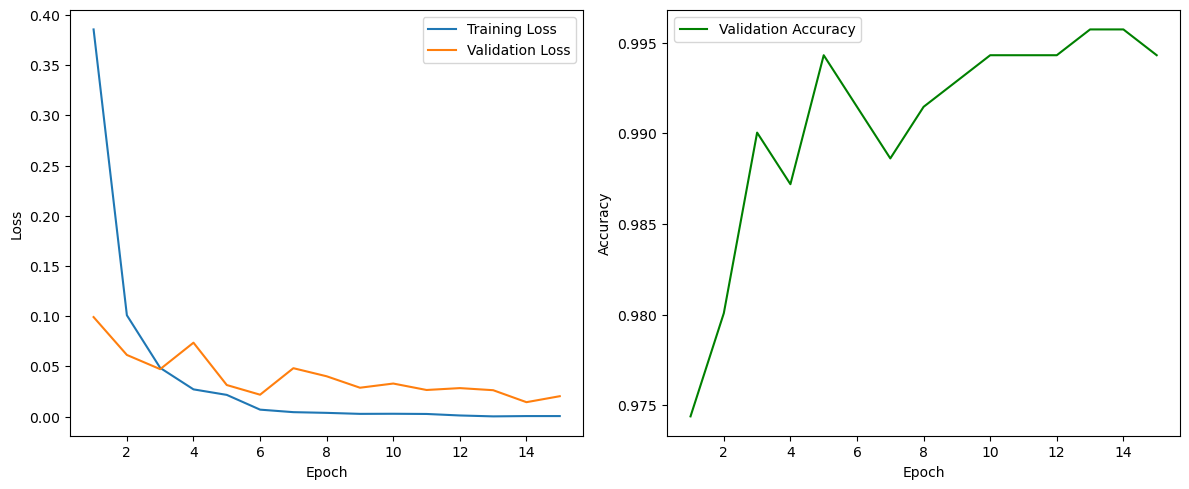

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("resnet_stats.png")
plt.show()


In [16]:
# inference
from PIL import Image
import torch
import time

# Load fine-tuned components
model_path = "./resnet-brain-tumor-final"
model = ResNetForImageClassification.from_pretrained(model_path).to("mps")
processor = AutoImageProcessor.from_pretrained(model_path)

# inference function
def predict(image_path, num_runs=10):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, return_tensors="pt").to("mps")  # Match device
    
    # Warmup (optional)
    with torch.no_grad():
        _ = model(**inputs)

    # Timed inference
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    inference_time = time.time() - start_time

    # For stable metrics, average over multiple runs
    total_time = 0
    for _ in range(num_runs):
        start = time.time()
        with torch.no_grad():
            _ = model(**inputs)
        total_time += time.time() - start
    
    # Get predictions
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    
    return {
        "prediction": predicted_class,
        "inference_time_single": inference_time,
        "inference_time_avg": total_time / num_runs,
        "probabilities": torch.nn.functional.softmax(logits, dim=-1)
    }

In [17]:
# Example usage
result = predict("images/_0_0.png")
result

{'prediction': 0,
 'inference_time_single': 0.007836103439331055,
 'inference_time_avg': 0.006743431091308594,
 'probabilities': tensor([[9.9984e-01, 2.7526e-05, 1.1749e-04, 1.2590e-05]], device='mps:0')}

In [24]:
# Get predictions on validation set
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Get class names
class_names = val_ds.features["label"].names
len(val_dataset)

703

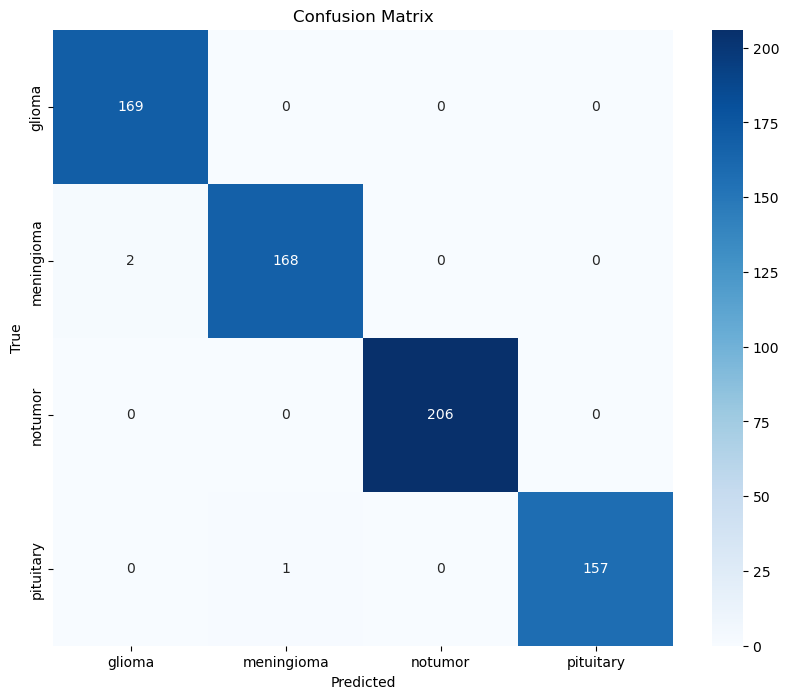

In [25]:
# classifcation report and confusion matrix
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("./confusion_matrix_resnet.png")
    plt.show()

plot_confusion_matrix(labels, preds, class_names=class_names)